In [34]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import src.basic_function_cap as bfc
import src.piano_key_notes as pkn
import ipywidgets as widgets
from ipywidgets import interact

# Crop video

In [2]:
cap = cv2.VideoCapture('mp4/autumn_leaves.mp4')

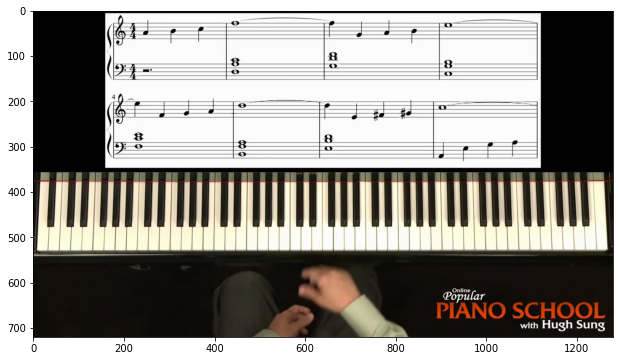

In [3]:
bfc.show_frame(cap, 219)
_, frame = bfc.get_frame(cap, 219)

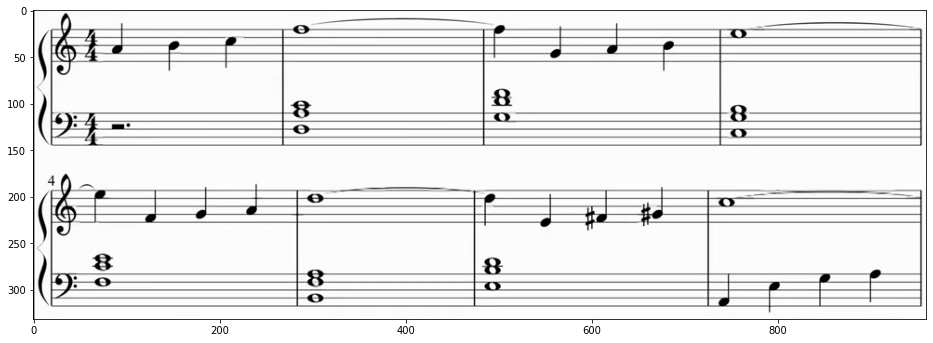

In [30]:
cropped_sheets = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)

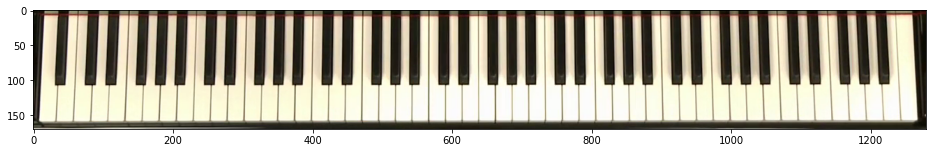

In [4]:
cropped = bfc.crop_frame(frame, 370, 0, 540-370, frame.shape[1], show=True)

In [31]:
# bfc.crop_and_save_video(cap, 370, 0, 540-370, frame.shape[1], 'mp4/autumn_cropped.mp4', 219, 32*32-10)
# bfc.crop_and_save_video(cap, 8, 158, 340-8, 960, 'mp4/autumn_partition.mp4', 219, 32*32-10)

OpenCV: FFMPEG: tag 0x34363268/'h264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


# Get notes

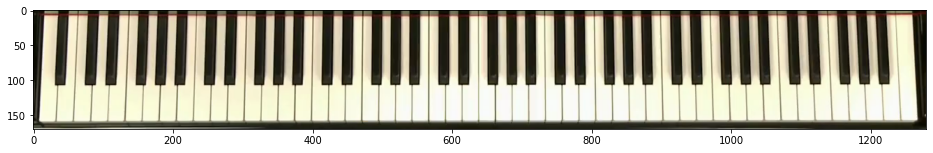

In [6]:
cap = cv2.VideoCapture('mp4/autumn_cropped.mp4')
bfc.show_frame(cap, 0)
image = bfc.get_frame(cap, 0)[1]

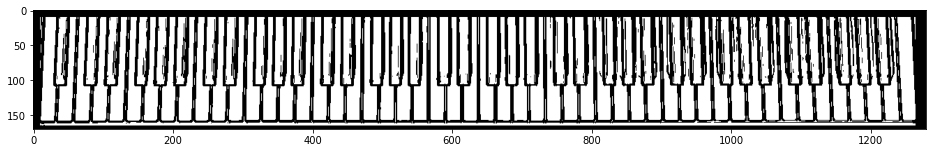

Number of connected components: 88


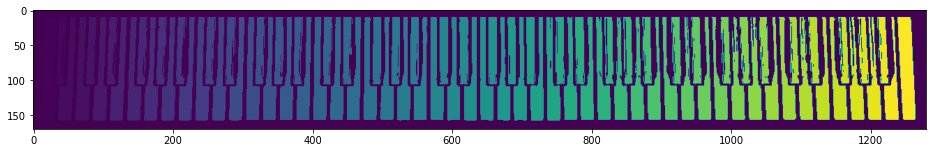

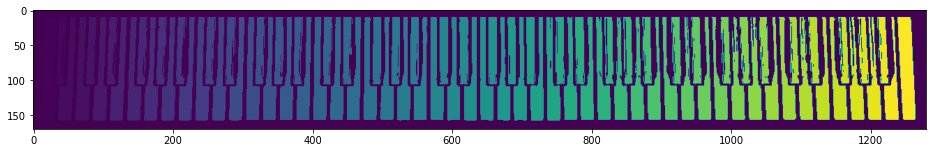

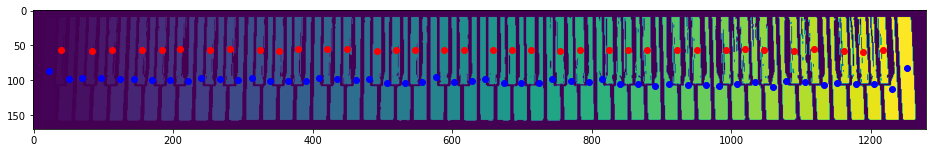

  0%|          | 0/36 [00:00<?, ?it/s]

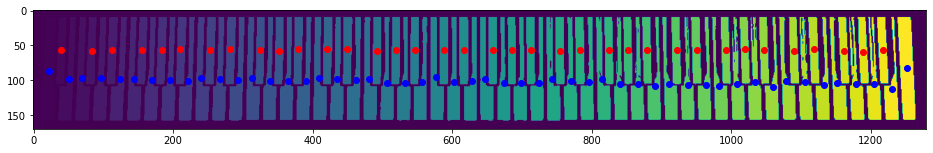

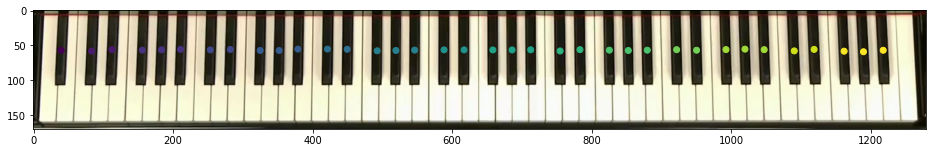

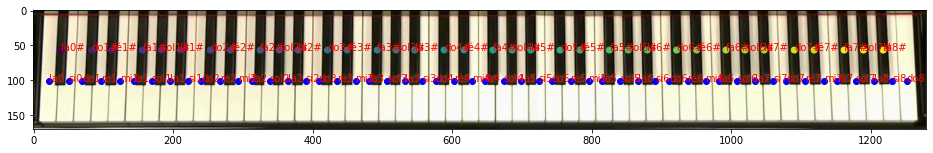

In [7]:
pipe = pkn.pipeline(image, with_hull=True, threshold = 4000, kx=20, crop=[10,5,10,15], min_area=200, max_width=200, show=True)
labels, black_keys, white_keys, n_labels, stats, centroids, group, notes, sobel = pipe

# Hightlight notes from sheet

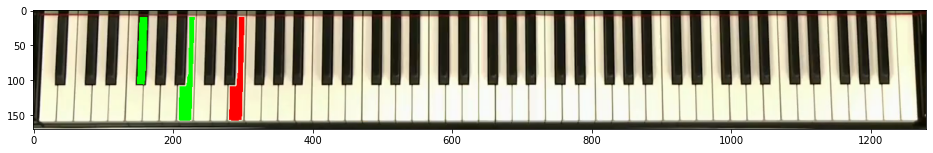

In [9]:
g = [0,255,0]
b = [0,0,255]
r = [255,0,0]
_ = pkn.highlight_keys(image=image, labels=labels, keys = [10,15,20], color = [g,g,r], show=True)

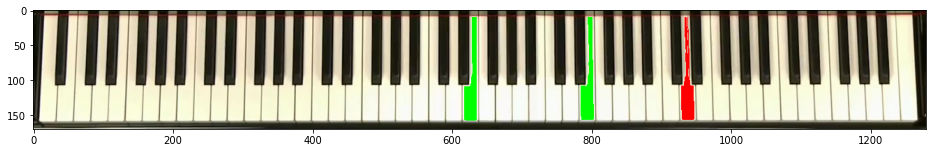

In [11]:
_ = pkn.highlight_notes(image=image, labels=labels, notes = ["mi4", "mi5", "ré6"], dict_notes = notes, color = [g,g,r], show=True)

# Get difference

In [17]:
cap = cv2.VideoCapture('mp4/autumn_leaves.mp4')

def show_frame(frame_number, shift):
    _, mask = bfc.get_frame(cap, 219)
    _, frame = bfc.get_frame(cap, 219+frame_number)
    mask = bfc.crop_frame(mask, 330, 0, 540-330, frame.shape[1])
    frame = bfc.crop_frame(frame, 330, 0, 540-330, frame.shape[1])
    plt.figure(figsize=(16,16))
    plt.imshow(frame)
    plt.show()
    plt.figure(figsize=(16,16))
    plt.imshow(frame - mask + shift)
    plt.show()

interact(show_frame,
        frame_number=widgets.IntSlider(min=0, max=32*32-10, step=1, value=100),
        shift=widgets.IntSlider(min=0, max=30, step=1, value=0))

interactive(children=(IntSlider(value=100, description='frame_number', max=1014), IntSlider(value=0, descripti…

<function __main__.show_frame(frame_number, shift)>

In [19]:
def show_frame(key_number):
    pkn.highlight_key_from_image(image=image, labels=labels, key_number = key_number, show=True)

interact(show_frame,
        key_number=widgets.IntSlider(min=0, max=n_labels, step=1, value=0))

interactive(children=(IntSlider(value=0, description='key_number', max=89), Output()), _dom_classes=('widget-i…

<function __main__.show_frame(key_number)>

# Read partition

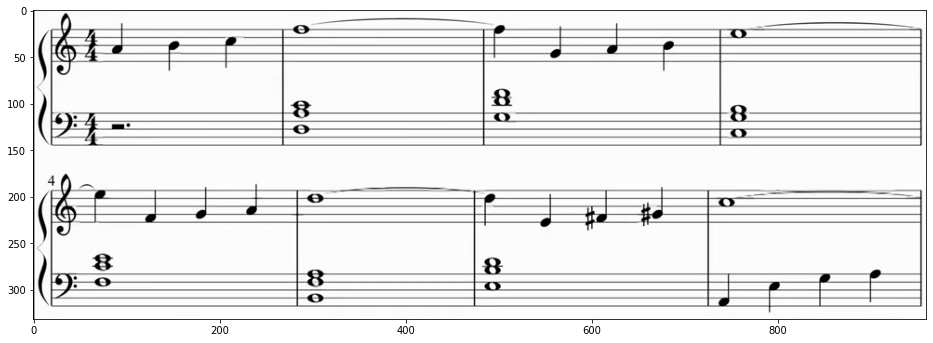

In [37]:
cap = cv2.VideoCapture('mp4/autumn_leaves.mp4')
_, frame = bfc.get_frame(cap, 219)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)

In [52]:
def dilate_img(img, kernel_size_x=3, kernel_size_y=3, iterations=1, show = False):
    kernel = np.ones((kernel_size_x, kernel_size_y), np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = iterations)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(dilation)
        plt.show()
    return dilation

def erode_img(img, kernel_size_x=3, kernel_size_y=3, iterations=1, show = False):
    kernel = np.ones((kernel_size_x, kernel_size_y), np.uint8)
    erosion = cv2.erode(img,kernel,iterations = iterations)
    if show:
        plt.figure(figsize=(16,6))
        plt.imshow(erosion)
        plt.show()
    return erosion

In [150]:
def get_black_notes(img):

    dilated = dilate_img(img, 8, 6, show = False)
    eroded = erode_img(dilated, 8, 6, show = False)

    gray = np.float32(cv2.cvtColor(eroded,cv2.COLOR_BGR2GRAY))

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = (sobel / sobel.max()*255).astype(np.uint8)

    black_white_threshold = 50
    sobel[sobel <= black_white_threshold] = 0
    sobel[sobel > black_white_threshold] = 255

    circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 15, param1 = 1, param2 = 6,
                                minRadius = 5,
                                maxRadius = 7
                            )
    circles = np.uint16(np.around(circles))

    img_circles = img.copy()
    for i in circles[0,:]:
        cv2.circle(img_circles,(i[0],i[1]),i[2],(0,255,0),2)

    plt.figure(figsize=(16,6))
    plt.imshow(img_circles)
    plt.show()

    return circles


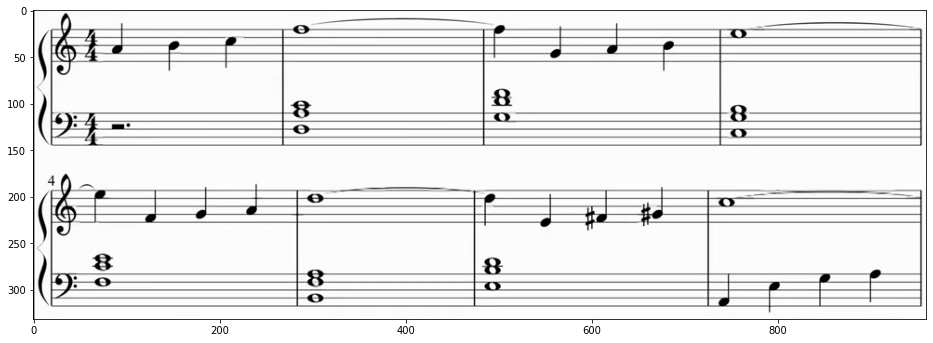

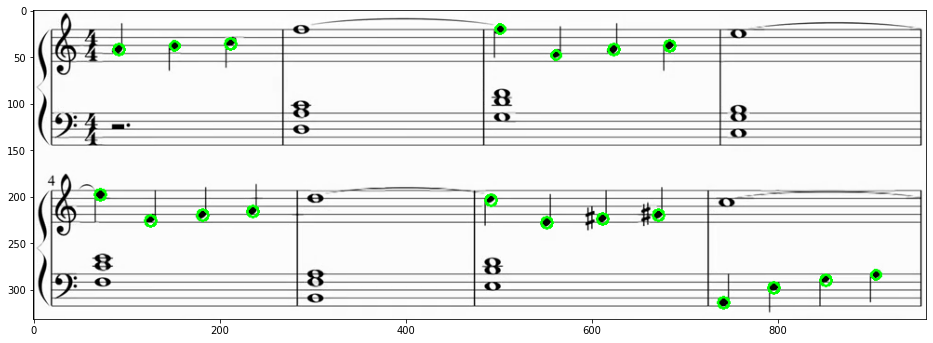

In [151]:
cap = cv2.VideoCapture('mp4/autumn_leaves.mp4')
_, frame = bfc.get_frame(cap, 219)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=True)
_ = get_black_notes(img)

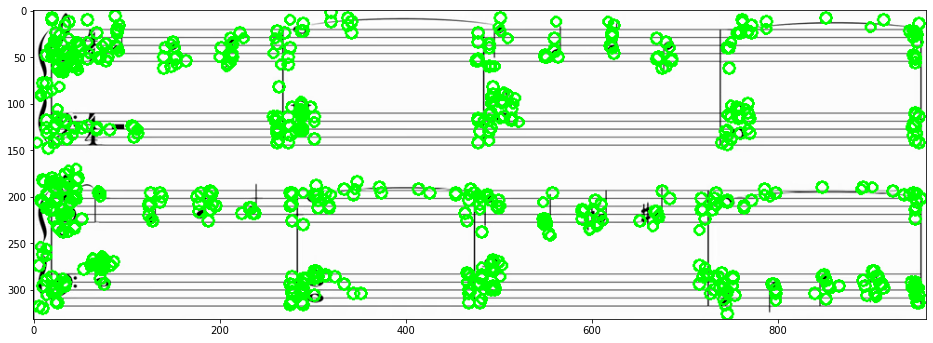

In [153]:
def get_white_notes(img, kx=3, ky=3, dp = 1,
                                minDist = 1, param1 = 1, param2 = 5,
                                minRadius = 5,
                                maxRadius = 7):

    #dilated = dilate_img(img, 8, 6, show = False)
    #eroded = erode_img(dilated, 8, 6, show = False)

    gray = np.uint8(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
    inverse = 255 - gray
    eroded = erode_img(inverse, kx, ky, show = False)

    #plt.figure(figsize=(16,6))
    #plt.imshow(eroded)
    #plt.show()

    circles = cv2.HoughCircles(eroded, cv2.HOUGH_GRADIENT, dp = dp, minDist = minDist, param1 = param1, param2 = param2,
                                minRadius = minRadius,
                                maxRadius = maxRadius
                            )
    circles = np.uint16(np.around(circles))

    img_circles = img.copy()
    for i in circles[0,:]:
        cv2.circle(img_circles,(i[0],i[1]),i[2],(0,255,0),2)

    plt.figure(figsize=(16,6))
    plt.imshow(img_circles)
    plt.show()

    return circles

cap = cv2.VideoCapture('mp4/autumn_leaves.mp4')
_, frame = bfc.get_frame(cap, 219)
img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
_ = get_white_notes(img)

In [161]:
# slider to find the best parameters

def show_frame(frame_number, kx, ky, dp, minDist, param1, param2, minRadius, maxRadius):
    _, frame = bfc.get_frame(cap, frame_number)
    img = bfc.crop_frame(frame, 8, 158, 340-8, 960, show=False)
    _ = get_white_notes(img, kx, ky, dp, minDist, param1, param2, minRadius, maxRadius)

interact(show_frame,
        frame_number=widgets.IntSlider(min=200, max=1000, step=1, value=219),
        kx=widgets.IntSlider(min=1, max=10, step=1, value=2),
        ky=widgets.IntSlider(min=1, max=10, step=1, value=3),
        dp=widgets.IntSlider(min=1, max=10, step=1, value=1),
        minDist=widgets.IntSlider(min=1, max=10, step=1, value=5),
        param1=widgets.IntSlider(min=1, max=10, step=1, value=5),
        param2=widgets.IntSlider(min=1, max=10, step=1, value=7),
        minRadius=widgets.IntSlider(min=1, max=10, step=1, value=5),
        maxRadius=widgets.IntSlider(min=1, max=10, step=1, value=7)
        )

interactive(children=(IntSlider(value=219, description='frame_number', max=1000, min=200), IntSlider(value=2, …

<function __main__.show_frame(frame_number, kx, ky, dp, minDist, param1, param2, minRadius, maxRadius)>